In [2]:
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-1.10.0+cu113.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-1.10.0+cu113.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git
!pip install ogb
!git clone https://github.com/m-k-S/neural-mechanics-geometric.git

fatal: destination path 'neural-mechanics-geometric' already exists and is not an empty directory.


In [13]:
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool
from torch_geometric.nn.norm import GraphNorm, PairNorm, MessageNorm, DiffGroupNorm, BatchNorm

from ogb.graphproppred import PygGraphPropPredDataset
from torch.utils.data import random_split
from torch_geometric.datasets import TUDataset, QM9, GNNBenchmarkDataset
from torch_geometric.loader import DataLoader

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [4]:
# Hacky but convenient
# Re-run upon code changes to the utilities code (for cleanliness/conciseness)
!cd neural-mechanics-geometric/ && git pull

import sys
sys.path.append('./neural-mechanics-geometric')

from importlib import reload
import order_parameters
reload(order_parameters)
import data_utils
reload(data_utils)

from order_parameters import Activs_prober, Conv_prober
from data_utils import initial_order_params, save_order_params, clear_order_params

Already up to date.


In [5]:
# dataset = PygGraphPropPredDataset(name = 'ogbg-molhiv')
# dataset = QM9(root='data/QM9')
dataset = TUDataset(root='data/TUDataset', name='PROTEINS_full', use_node_attr=True)
train_dataset, test_dataset = random_split(dataset, [int(len(dataset) * 0.8), int(len(dataset) * 0.2) + 1])

try:
    split_idx = dataset.get_idx_split() 
    train_loader = DataLoader(dataset[split_idx['train']], batch_size=64, shuffle=True)
    test_loader = DataLoader(dataset[split_idx['test']], batch_size=64, shuffle=False)
except AttributeError:
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


print()
print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

Extracting data/TUDataset/PROTEINS_full/PROTEINS_full.zip
Processing...



Dataset: PROTEINS_full(1113):
Number of graphs: 1113
Number of features: 32
Number of classes: 2


Done!


In [27]:
class GCN(torch.nn.Module):
    def __init__(self, hidden_channels, num_layers=3, norm=None, norm_args=None):
        # Normalization layers need specific kwargs:
        # BatchNorm: in_channels (int)
        # GraphNorm: in_channels (int)
        # PairNorm: scale (int)
        # DiffGroupNorm: in_channels (int), groups (int)
        super(GCN, self).__init__()
        self.num_layers = num_layers

        norm_map = {'BatchNorm': BatchNorm, 'GraphNorm': GraphNorm, 'PairNorm': PairNorm, 'DiffGroupNorm': DiffGroupNorm}
        self.norm = norm

        self.conv_layers = nn.ModuleList()
        self.conv_probes = nn.ModuleList()
        self.norm_layers = nn.ModuleList()
        self.activations = nn.ModuleList()
        self.activ_probes = nn.ModuleList()

        for l in range(num_layers):
            if l == 0:
                self.conv_layers.append(GCNConv(dataset.num_node_features, hidden_channels))
            else: 
                self.conv_layers.append(GCNConv(hidden_channels, hidden_channels))

            self.conv_probes.append(Conv_prober())
            if norm:
                if norm_args:
                    self.norm_layers.append(norm_map[norm](**norm_args))
                else: 
                    self.norm_layers.append(norm_map[norm]())
                    
            self.activations.append(nn.ReLU(inplace=True))
            self.activ_probes.append(Activs_prober())

        self.lin = torch.nn.Linear(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index, batch):
        for l in range(self.num_layers):
            x = self.conv_layers[l](x, edge_index)
            x = self.conv_probes[l](x, batch)
            if self.norm:
                x = self.norm_layers[l](x)
            x = self.activations[l](x)
            x = self.activ_probes[l](x, batch)

        x = global_mean_pool(x, batch)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)

        return x

In [28]:
def train():
    model.train()

    for data in train_loader:  # Iterate in batches over the training dataset.
        x = data.x.type(torch.FloatTensor).to(device)
        edge_index = data.edge_index.to(device)
        batch = data.batch.to(device)

        out = model(x, edge_index, batch)  # Perform a single forward pass.
        y = data.y.flatten().to(device)

        loss = criterion(out, y)  # Compute the loss.
        loss.backward()  # Derive gradients. 

        optimizer.step()  # Update parameters based on gradients.
        optimizer.zero_grad()  # Clear gradients.

def test(loader):
    model.eval()

    correct = 0
    for data in loader:  # Iterate in batches over the training/test dataset.
        x = data.x.type(torch.FloatTensor).to(device)
        edge_index = data.edge_index.to(device)
        batch = data.batch.to(device)

        y = data.y.to(device)
        out = model(x, edge_index, batch)

        pred = out.argmax(dim=1)  # Use the class with highest probability.
        correct += int((pred == y).sum())  # Check against ground-truth labels.

        roc_y = y.clone().detach().cpu()
        roc_out = pred.clone().detach().cpu()
        roc_auc = roc_auc_score(roc_y, roc_out)
    return correct / len(loader.dataset), roc_auc  # Derive ratio of correct predictions.

if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

epochs = 50
hidden_channels = 64
depths = torch.arange(3, 35, 2)

initial_activs_all = {}
initial_grads_all  = {}

# Loop for getting initial activation and gradient norms (for a full training epoch, i.e. over all samples)
# Iterate over different normalization types
for norm_setting in [None, 'BatchNorm', 'GraphNorm', 'PairNorm', 'DiffGroupNorm']:

    # Iterate over different model depths
    for depth in tqdm(depths):

        if norm_setting == 'DiffGroupNorm':
            group_sizes = (np.array([0.5, 0.25, 0.125, 0.0625]) * dataset.num_features).astype(int)
            for group in group_sizes:
                norm_args = {'in_channels': hidden_channels, 'groups': group}

                name = '{}_{}_{}'.format(norm_setting, depth, group)
            
                # Define model, optimizer, and loss
                model = GCN(hidden_channels=hidden_channels, num_layers=depth, norm=norm_setting, norm_args=norm_args).to(device)
                optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
                criterion = torch.nn.CrossEntropyLoss()

                # The mean of the initial activations and gradients are saved in these dictionaries; the keys are the corresponding layers
                initial_activs, initial_grads = initial_order_params(model, train_loader, criterion, optimizer, device)

                initial_activs_all[name] = initial_activs
                initial_grads_all[name] = initial_grads

        else:
            if norm_setting == 'BatchNorm' or norm_setting == 'GraphNorm':
                norm_args = {'in_channels': hidden_channels}
            else:
                norm_args = None

            name = '{}_{}'.format(str(norm_setting), depth)

            # Define model, optimizer, and loss
            model = GCN(hidden_channels=hidden_channels, num_layers=depth, norm=norm_setting, norm_args=norm_args).to(device)
            optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
            criterion = torch.nn.CrossEntropyLoss()

            # The mean of the initial activations and gradients are saved in these dictionaries; the keys are the corresponding layers
            initial_activs, initial_grads = initial_order_params(model, train_loader, criterion, optimizer, device)

            initial_activs_all[name] = initial_activs
            initial_grads_all[name] = initial_grads

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

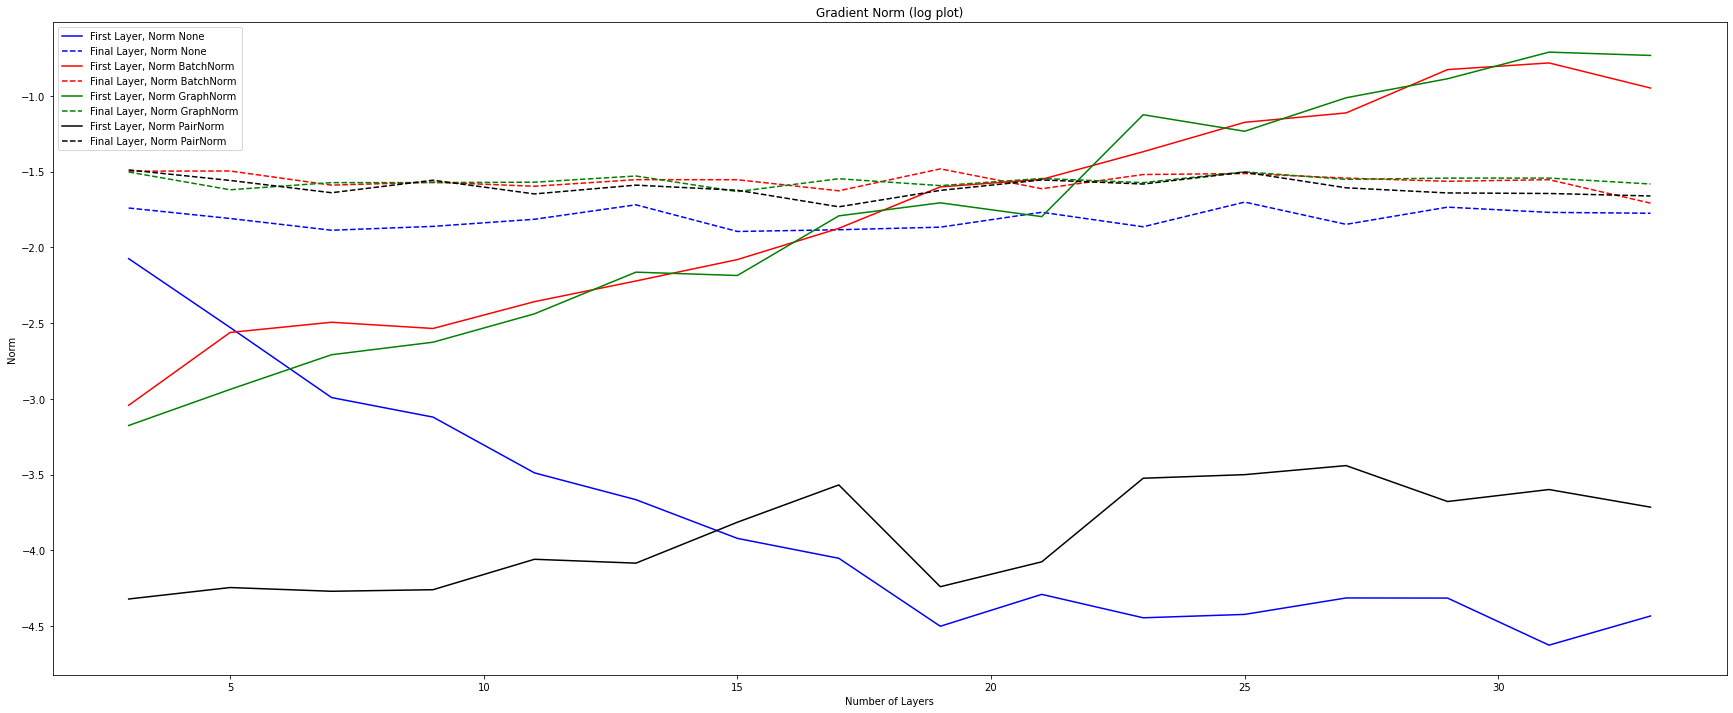

In [47]:
def get_norm_by_layer(order_param, title):
    # Plot: 
    # First layer gradient norm vs. depth, for each normalization setting
    # Final layer gradient norm vs. depth, for each normalization setting

    plt.figure(figsize=(30, 12))
    plt.title(title)
    plt.xlabel("Number of Layers")
    plt.ylabel("Norm")

    names = list(order_param.keys())
    norms = [n.split("_")[0] for n in names]
    norms = [i for n, i in enumerate(norms) if i not in norms[:n]]

    for linestyle, norm in zip(['b', 'r', 'g', 'k'], norms):

        if norm != "DiffGroupNorm":

            Layer1 = []
            LayerF = []

            for depth in depths:

                depth = depth.item()

                Layer1.append(order_param['{}_{}'.format(norm, depth)][0])
                LayerF.append(order_param['{}_{}'.format(norm, depth)][depth-1])

            plt.plot(depths, np.log10(Layer1), '{}-'.format(linestyle), label="First Layer, Norm {}".format(norm))
            plt.plot(depths, np.log10(LayerF), '{}--'.format(linestyle), label="Final Layer, Norm {}".format(norm))

    plt.legend()
    plt.show()

get_norm_by_layer(initial_grads_all, "Gradient Norm (log plot)")

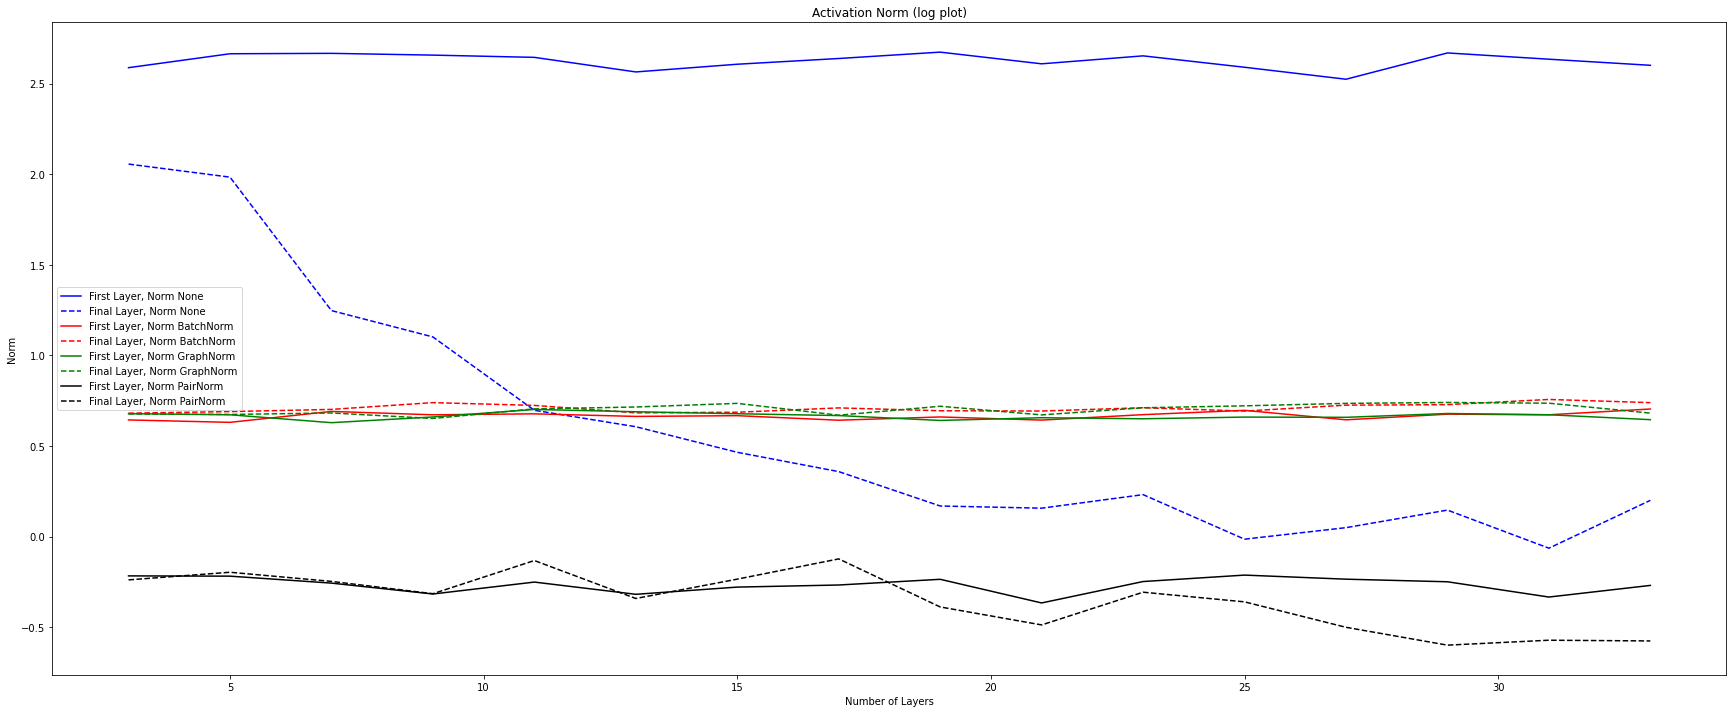

In [48]:
get_norm_by_layer(initial_activs_all, "Activation Norm (log plot)")

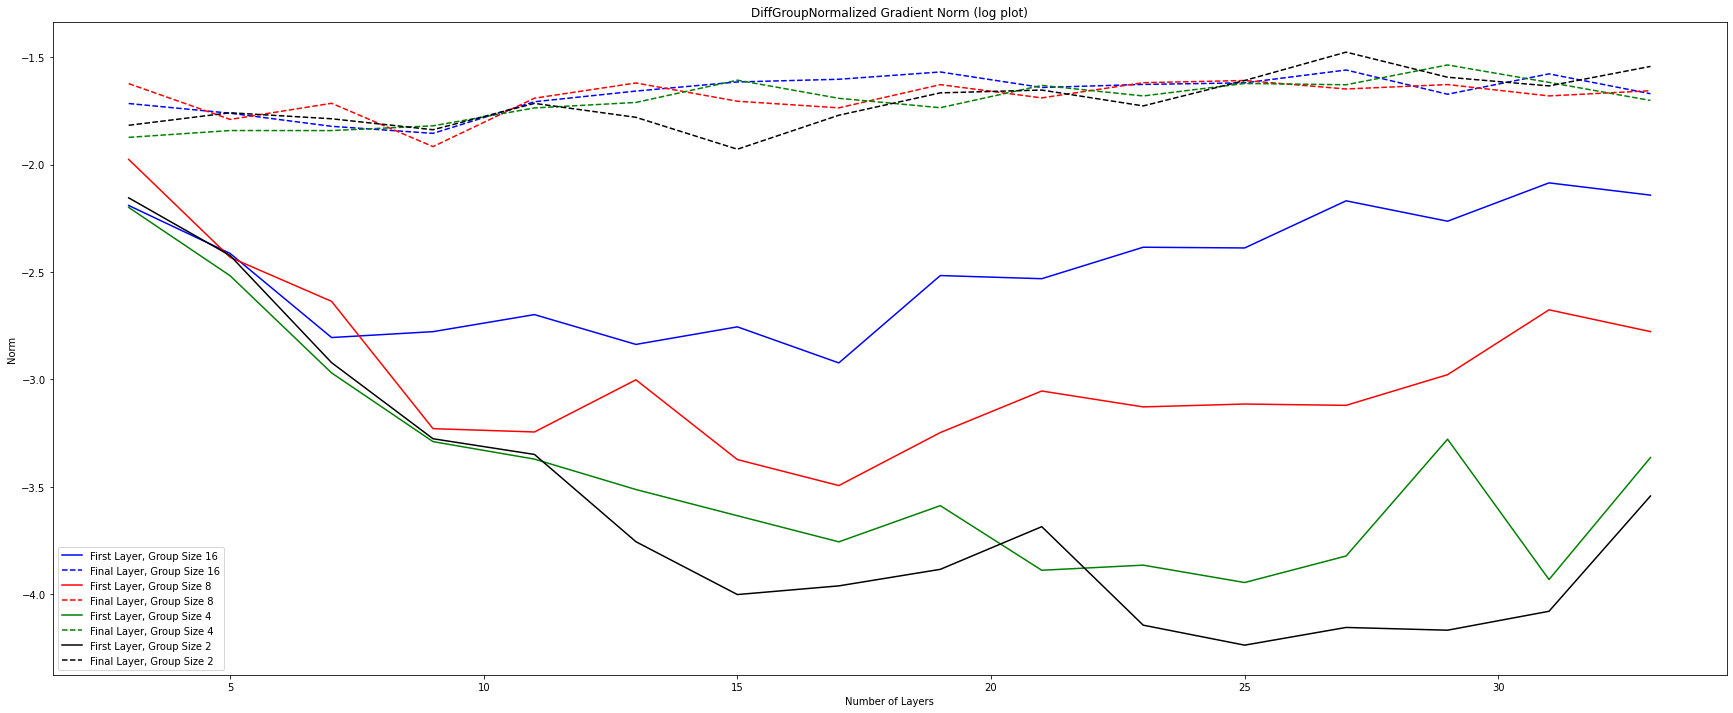

In [50]:
group_sizes = (np.array([0.5, 0.25, 0.125, 0.0625]) * dataset.num_features).astype(int)

plt.figure(figsize=(30, 12))
plt.title('DiffGroupNormalized Gradient Norm (log plot)')
plt.xlabel("Number of Layers")
plt.ylabel("Norm")

norm = 'DiffGroupNorm'

for linestyle, group in zip(['b', 'r', 'g', 'k'], group_sizes):
    Layer1 = []
    LayerF = []

    for depth in depths:

        depth = depth.item()

        Layer1.append(initial_grads_all['{}_{}_{}'.format(norm, depth, group)][0])
        LayerF.append(initial_grads_all['{}_{}_{}'.format(norm, depth, group)][depth-1])

    plt.plot(depths, np.log10(Layer1), '{}-'.format(linestyle), label="First Layer, # of Groups {}".format(group))
    plt.plot(depths, np.log10(LayerF), '{}--'.format(linestyle), label="Final Layer, # of Groups {}".format(group))

plt.legend()
plt.show()

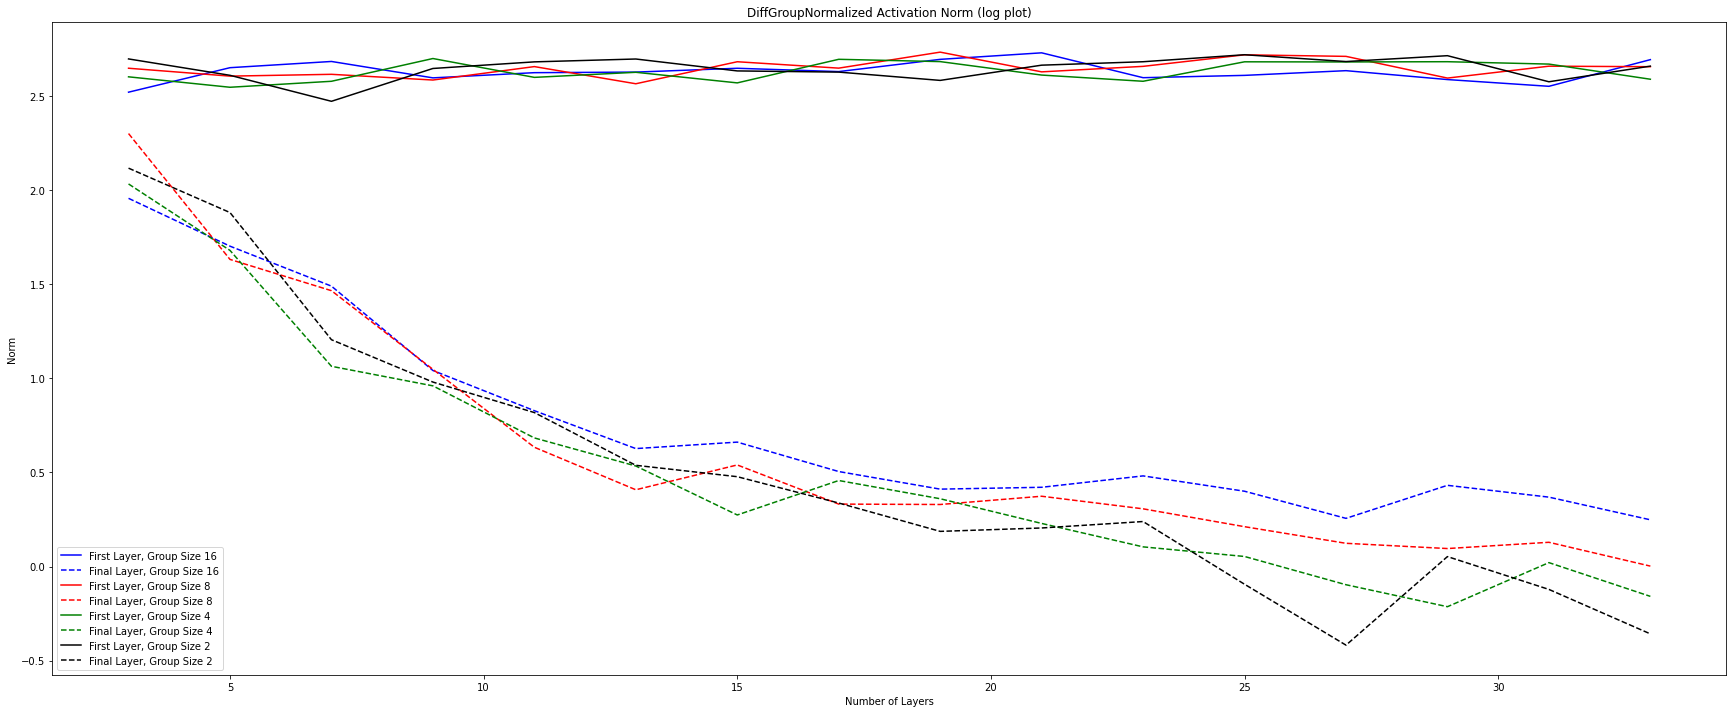

In [52]:
group_sizes = (np.array([0.5, 0.25, 0.125, 0.0625]) * dataset.num_features).astype(int)

plt.figure(figsize=(30, 12))
plt.title('DiffGroupNormalized Activation Norm (log plot)')
plt.xlabel("Number of Layers")
plt.ylabel("Norm")

norm = 'DiffGroupNorm'

for linestyle, group in zip(['b', 'r', 'g', 'k'], group_sizes):
    Layer1 = []
    LayerF = []

    for depth in depths:

        depth = depth.item()

        Layer1.append(initial_activs_all['{}_{}_{}'.format(norm, depth, group)][0])
        LayerF.append(initial_activs_all['{}_{}_{}'.format(norm, depth, group)][depth-1])

    plt.plot(depths, np.log10(Layer1), '{}-'.format(linestyle), label="First Layer, # of Groups {}".format(group))
    plt.plot(depths, np.log10(LayerF), '{}--'.format(linestyle), label="Final Layer, # of Groups {}".format(group))

plt.legend()
plt.show()

In [11]:
# Training loop
# Iterate over different normalization types
for norm_setting in [None, 'BatchNorm', 'GraphNorm', 'PairNorm', 'DiffGroupNorm']:

    # Iterate over different model depths
    for depth in tqdm(depths):

            # Normalization layer params
        if norm_setting == 'BatchNorm' or norm_setting == 'GraphNorm':
            norm_params = {'in_channels': hidden_channels}
                        
        elif norm_setting == 'DiffGroupNorm':
            norm_params = {'in_channels': hidden_channels, ''}

        name = 'depth{}'.format(depth)

        # Define model, optimizer, and loss
        model = GCN(hidden_channels=hidden_channels, num_layers=depth, norm=norm_setting, ).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
        criterion = torch.nn.CrossEntropyLoss()

        accuracies = {'test_acc': [], 'train_acc': []}

        # Training loop
        for epoch in tqdm(range(1, epochs+1)):
            train()
            train_acc, train_roc = test(train_loader)
            test_acc, test_roc = test(test_loader)
            accuracies['test_acc'].append(test_acc)
            accuracies['train_acc'].append(train_acc)
            print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}, Train ROCAUC: {train_roc:.4f}, Test ROCAUC: {test_roc:.4f}')
        
        final_train_acc[name] = train_acc
        final_test_acc[name] = test_acc

SyntaxError: ignored

In [ ]:
activs, grads = save_order_params(model)

n_batches = len(train_loader)

plt.figure(figsize=(20, 10))
for l in range(1, n_layers+1):
    plt.plot([i for i in range(epochs * n_batches)], activs['Layer {}'.format(l)])
plt.show()

plt.figure(figsize=(20, 10))
for l in range(1, n_layers+1):
    plt.plot([i for i in range(epochs * n_batches)], grads['Layer {}'.format(l)])
plt.show()


NameError: ignored

<Figure size 1440x720 with 0 Axes>